Reference:

https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
from itertools import combinations


In [2]:
file_path = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project/train.csv'
df = pd.read_csv(file_path)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [32]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Toxic and non-toxic first

In [3]:
df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

Dealing with imbalanced data. Keep all 15294 rows for toxic comments and 16000 rows from non-toxic comments

In [4]:
# filter for only non-toxic comments 
non_toxic_df = df[df['toxic'] == 0]

# randomly sample 16000 rows from this dataframe 
non_toxic_df_sample = non_toxic_df.sample(n=16000, random_state=42)

# get only the rows with toxic comments 
toxic_df = df[df['toxic'] == 1]

# concat both dataframes and shuffle the rows 
comment_df = pd.concat([non_toxic_df_sample, toxic_df])
comment_df = comment_df.sample(frac=1).reset_index(drop=True)
comment_df


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,73aeca9ac47fc045,This article is a piece of dogshit written by ...,1,0,1,0,1,0
1,d21bd0dd8173a568,You... \n\nI think you are a horrible person. ...,1,0,0,0,0,0
2,63b2199ab0ed0bcb,"Well, dark green is the color of Islam, so lig...",0,0,0,0,0,0
3,0273ce236b01e35f,Why?\nDo you really have to do that. I know it...,0,0,0,0,0,0
4,c5430437bdd174a2,i hope you die you fucking pedophile. i gave y...,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...
31289,8a989b5ff3b5b36a,", I fail to see any reason to shift away from ...",0,0,0,0,0,0
31290,7dbc1e99ae628417,I too am a gay pedophile,1,0,0,0,0,1
31291,ded9557446dce740,"""The """"Calypso"""" in Pirates of the Caribbean: ...",0,0,0,0,0,0
31292,72c2d8fc8ff35b38,Thanks for the heads up asshole.,1,0,1,0,1,0


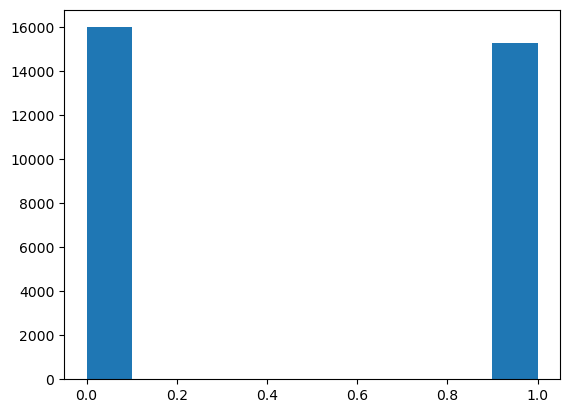

In [5]:
plt.hist(comment_df['toxic'])
plt.show()

### Tokenize using keras

In [6]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2023-05-15 19:49:59.515536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
sentences = comment_df['comment_text'].values
y = comment_df['toxic'].values
sentences

array(["This article is a piece of dogshit written by pigfuckers\n\nThere's no reason for this in a general interest encyclopedia.  Take it to the Battlestar Wiki.  It's garbage, and I'd like to see it deleted.",
       "You... \n\nI think you are a horrible person. I really don't want to cause Wikihate but I don't like the way you are. You insult the president. you insult me, you are all fancy with your achives! It makes me sick!\nOoohh, look at me, I have an Archive 01! It's so annoying. Don't you realise this?",
       'Well, dark green is the color of Islam, so light green does sort of make sense. Is it possible for you to make a new version of the map that shows pluralities/equal religions somehow? And also, its accepted that Lebanon is a Muslim country, coloring it in as Catholic would be misleading.  Talk|Contribs',
       ...,
       '"The ""Calypso"" in Pirates of the Caribbean: At World\'s End is NOT the Calypso of Greek mythology.  As far as I know, the only similarity is th

In [8]:
sentences_train, sentences_test, y_train, y_test = train_test_split(
                                                sentences, y,  
                                                test_size=0.25,  
                                                random_state=42)

In [9]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences_train)

In [10]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [11]:
# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1


maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Get GloVe pre-trained embeddings

In [12]:


VECTOR_CACHE_DIR = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project'

# glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)
glove = GloVe(name='6B')


words = ["hello", "hi", "king", "president"]
vecs = glove.get_vecs_by_tokens(words)

In [13]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                                        vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [14]:
embedding_dim = 50
glove_filepath = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project/glove.6B/glove.6B.50d.txt'
embedding_matrix = create_embedding_matrix(glove_filepath, tokenizer.word_index, embedding_dim)



In [15]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.18000013e-01,  2.49679998e-01, -4.12420005e-01, ...,
        -1.84110001e-01, -1.15139998e-01, -7.85809994e-01],
       [-1.09190005e-03,  3.33240002e-01,  3.57430011e-01, ...,
        -4.56970006e-01, -4.89690006e-02,  1.13160002e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [25]:
## TRAINING THE MODEL 

from keras.models import Sequential
from keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          5811700   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,877,129
Trainable params: 5,877,129
Non-trainable params: 0
____________________________________________

In [34]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/10
2347/2347 [==============================] - 39s 17ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.3715 - val_accuracy: 0.8990
Epoch 2/10
2347/2347 [==============================] - 40s 17ms/step - loss: 0.0134 - accuracy: 0.9968 - val_loss: 0.4191 - val_accuracy: 0.8988
Epoch 3/10
2347/2347 [==============================] - 39s 17ms/step - loss: 0.0082 - accuracy: 0.9980 - val_loss: 0.5334 - val_accuracy: 0.8998
Epoch 4/10
2347/2347 [==============================] - 38s 16ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.5200 - val_accuracy: 0.8972
Epoch 5/10
2347/2347 [==============================] - 42s 18ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.5708 - val_accuracy: 0.9003
Epoch 6/10
2347/2347 [==============================] - 40s 17ms/step - loss: 0.0056 - accuracy: 0.9979 - val_loss: 0.6168 - val_accuracy: 0.8979
Epoch 7/10
2347/2347 [==============================] - 40s 17ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.6253 -

734/734 [==============================] - 2s 3ms/step - loss: 0.0055 - accuracy: 0.9983
Training Accuracy: 0.9983
Testing Accuracy:  0.8978


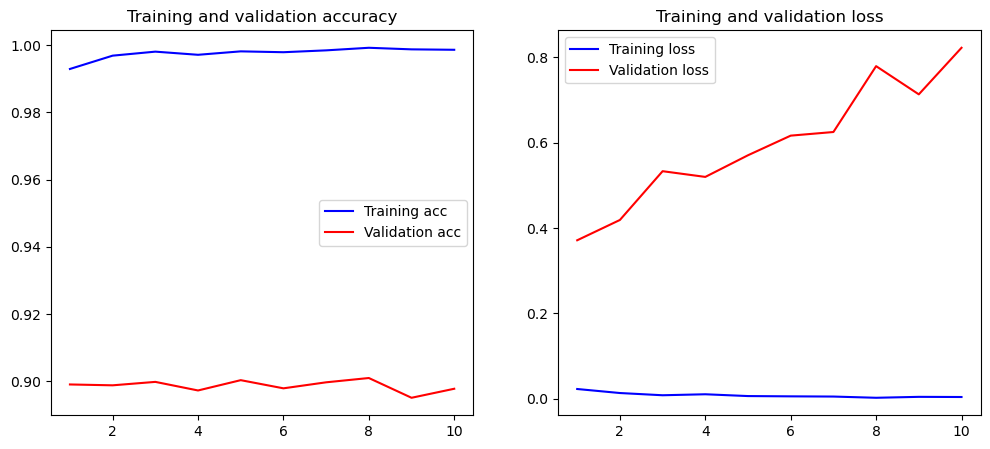

In [35]:
loss, accuracy = model.evaluate(X_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [36]:
history.history

{'loss': [0.022846948355436325,
  0.013432768173515797,
  0.008213069289922714,
  0.010526064783334732,
  0.006308788899332285,
  0.00564739340916276,
  0.00517117278650403,
  0.0022977131884545088,
  0.0044825077056884766,
  0.004093300085514784],
 'accuracy': [0.9928845167160034,
  0.9968470335006714,
  0.9980400800704956,
  0.997102677822113,
  0.9981252551078796,
  0.997869610786438,
  0.9984235167503357,
  0.9991904497146606,
  0.9987217783927917,
  0.9985939264297485],
 'val_loss': [0.3715130686759949,
  0.41911420226097107,
  0.5334278345108032,
  0.5200386047363281,
  0.5708221197128296,
  0.6167936325073242,
  0.6252784729003906,
  0.7796799540519714,
  0.7135633826255798,
  0.8227372169494629],
 'val_accuracy': [0.8990286588668823,
  0.8987730145454407,
  0.8997954726219177,
  0.8972392678260803,
  0.900306761264801,
  0.8978783488273621,
  0.8996676802635193,
  0.900945782661438,
  0.8950664401054382,
  0.8977504968643188]}